# Introduction

"All models are wrong, some are useful" - George box

This notebook analyzes effect of socio-demograhic trends on businesses, identifying those trends to make business decisions effectively. In today's world in highly competitive environment it is very crucial to take decisions in timely manner to stay in the game,to target right customers and right time, to run marketing campaign effectively to thrive int he business. This notebook experiments with the tools and geo-spatial dataset provided by Precisely. The primary goal of this hackathon is to determine if location that company wants to start its business is good or not. For this different datasets have been provided [details are in data evaluation/Engineering section] to analayze socio-demographic trends at that location. The mathematical model predicts not only recommendation about viablity of the location but also predicts revenue/Profitibility and hiring count at this location.

Since team has liberty to choose any one type of business and help them to determine next viable location for their business, after going through dataset Discover has chosen "Libraries" for performing analytics for this hackathon.  

One may argue that Libraries are not a business because they are not meant for making profits. But to sustain at any physical location involves cost and expenditure in different forms like employee cost, lease of property, contracts for books and what not.. If libraries are opened without doing any study about location then it may enventually incur financial loss and gets closed. It requires proper study and needs to have sustainable model. Then Libraries can do lot of things to maintain their monthly cost to stay at that location. Sustainable libraries are ultimately great indicator of social cohesiveness.[1]

# Business Understanding

The hackathon environent has provided data for wide range of businesses (Point of Interests, Yelp reviews). The goal of this hackathon is to provide insights for selected business from the provided datasets which includes point of interest, Yelp reviews for businesses, Consumer behvior/income, census and traffic data with the help from Geo-spatial Libraries provided by Precisely. The primary objective is to predict if particular location is suitable to start your business. The mathematical model should able to predict if the given address is suitable to start new branch/business along with estimated revenue and employees required.

Objective is provide insights for Libraries in United States from the data available and build a model to predict if new library can be opened at any given location and number of employees required and estimate revenues from the location.

# Data Evaluation/Engineering

### Point Of Interest Dataset
First step is to find records that are belong to all libraries. Hackthon's Point of Interest Dataset has total 23714 records i.e. these are total number of different locations for the libraries across United States. As shown in below cells libraries are located in all states although numbers are different for every state. There is only one library "
TANGIPAHOA PARISH LIBRARY" has 0 number employees in this data. The google search indicates this library at this location is closed and therefore removed from this analysis.

In [0]:
%sql 
select trade_division,group_name,main_class,count(*) from provided_datasets.usa_points_of_insterest_001 
where main_class='LIBRARIES' and employee_here>0 group by trade_division,group_name,main_class order by count(*) desc

trade_division group_name main_class count(1) DIVISION I. - SERVICES EDUCATIONAL SERVICES LIBRARIES 23714

## Python code to retrieve data
Before going into geospatial analysis below are diffrent statistics about libraries. Below cell contains code to retrive data for visualizations. Next cells contains visuals and decription of the plots.

In [0]:
top_20_states = spark.sql("select STABB,count(*) total_libraries  from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by STABB order by count(*) desc limit 20").toPandas()

top_20_states_emp = spark.sql("select STABB,SUM(EMPLOYEE_HERE) total_employees  from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by STABB order by SUM(EMPLOYEE_HERE) desc limit 20").toPandas()

top_20_by_libraries = spark.sql("select name,count(*) total_locations from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by count(*) desc limit 20").toPandas()

top_20_by_libby_emp = spark.sql("select name,SUM(EMPLOYEE_HERE) total_employees from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by SUM(EMPLOYEE_HERE) desc limit 20").toPandas()

top_20_by_sales = spark.sql("select name,SUM(SALES_VOLUME_US_DOLLARS) total_SALES from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by SUM(SALES_VOLUME_US_DOLLARS) desc limit 20").toPandas()

top_lib_by_state = spark.sql("select trim(STABB) State,trim(name) Name from provided_datasets.usa_points_of_insterest_001 where  main_class='LIBRARIES' and name IN ( select name from ( select name,SUM(SALES_VOLUME_LOCAL) total_SALES from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0 group by name order by SUM(SALES_VOLUME_LOCAL) desc limit 10))").toPandas()

all_libraries = spark.sql("select name,longitude,latitude,employee_here,sales_volume_us_dollars from provided_datasets.usa_points_of_insterest_001 where main_class='LIBRARIES' and employee_here <> 0").toPandas()

florida_lib_ds = spark.sql("select * from t_dis_poi_route50").toPandas()


In [0]:
pip install descartes


Python interpreter will be restarted.
Collecting descartes
 Downloading descartes-1.1.0-py3-none-any.whl (5.8 kB)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from descartes) (3.2.2)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (1.3.0)
Requirement already satisfied: numpy>=1.11 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (1.19.2)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (2.4.7)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (0.10.0)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->descartes) (2.8.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib->descartes) (1.15.0)
Installing collected packages: descartes
Successfully installed descartes-1.1.0
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-eb733063-c435-4e1d-bac9-8a1e9782dcc9/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install geopandas

Python interpreter will be restarted.
Collecting geopandas
 Downloading geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
Collecting fiona>=1.8
 Downloading Fiona-1.8.20-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (15.4 MB)
Requirement already satisfied: pandas>=0.25.0 in /databricks/python3/lib/python3.8/site-packages (from geopandas) (1.1.5)
Collecting shapely>=1.6
 Downloading Shapely-1.7.1-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
Collecting pyproj>=2.2.0
 Downloading pyproj-3.2.1-cp38-cp38-manylinux2010_x86_64.whl (6.3 MB)
Collecting click>=4.0
 Downloading click-8.0.3-py3-none-any.whl (97 kB)
Collecting attrs>=17
 Downloading attrs-21.2.0-py2.py3-none-any.whl (53 kB)
Requirement already satisfied: setuptools in /databricks/python3/lib/python3.8/site-packages (from fiona>=1.8->geopandas) (50.3.1)
Collecting cligj>=0.5
 Downloading cligj-0.7.2-py3-none-any.whl (7.1 kB)
Collecting click-plugins>=1.0
 Downloading click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Requirement already satisfied: six>=1.7 in /databricks/python3/lib/python3.8/site-packages (from fiona>=1.8->geopandas) (1.15.0)
Requirement already satisfied: certifi in /databricks/python3/lib/python3.8/site-packages (from fiona>=1.8->geopandas) (2020.12.5)
Collecting munch
 Downloading munch-2.5.0-py2.py3-none-any.whl (10 kB)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.25.0->geopandas) (2020.5)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.25.0->geopandas) (2.8.1)
Requirement already satisfied: numpy>=1.15.4 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.25.0->geopandas) (1.19.2)
Installing collected packages: click, attrs, cligj, click-plugins, munch, fiona, shapely, pyproj, geopandas
Successfully installed attrs-21.2.0 click-8.0.3 click-plugins-1.1.1 cligj-0.7.2 fiona-1.8.20 geopandas-0.10.2 munch-2.5.0 pyproj-3.2.1 shapely-1.7.1
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-eb733063-c435-4e1d-bac9-8a1e9782dcc9/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install plotly

Python interpreter will be restarted.
Requirement already satisfied: plotly in /databricks/python3/lib/python3.8/site-packages (4.14.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.15.0)
Requirement already satisfied: retrying>=1.3.3 in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.3.3)
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-eb733063-c435-4e1d-bac9-8a1e9782dcc9/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install yellowbrick

Python interpreter will be restarted.
Collecting yellowbrick
 Downloading yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
Requirement already satisfied: numpy<1.20,>=1.16.0 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (1.19.2)
Requirement already satisfied: matplotlib!=3.0.0,>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (3.2.2)
Requirement already satisfied: scikit-learn>=0.20 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (0.23.2)
Requirement already satisfied: scipy>=1.0.0 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (1.5.2)
Requirement already satisfied: cycler>=0.10.0 in /databricks/python3/lib/python3.8/site-packages (from yellowbrick) (0.10.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib!=3.0.0,>=2.0.2->yellowbrick) (2.4.7)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib!=3.0.0,>=2.0.2->yellowbrick) (2.8.1)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib!=3.0.0,>=2.0.2->yellowbrick) (1.3.0)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->yellowbrick) (2.1.0)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->yellowbrick) (0.17.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from cycler>=0.10.0->yellowbrick) (1.15.0)
Installing collected packages: yellowbrick
Successfully installed yellowbrick-1.3.post1
WARNING: You are using pip version 20.2.4; however, version 21.3 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-eb733063-c435-4e1d-bac9-8a1e9782dcc9/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import matplotlib.pyplot as plt
import descartes
import geopandas 
from shapely.geometry import Point, Polygon
%matplotlib inline

## Data Visualization from full Library dataset

This section shows some observations from the data using plots. This section includes insights from the all records available in point of interest dataset. 

### Limitation of the Hackathon environment

Analysis with all 23,714 distinct addresses apparently not possible in this environment. Geofencing fails with memory error (Java exception) when 400 distinct addreses are fed Spark engine. With 100 Geofencing succeeds but Spatital search fails with same Memory erros. Therefore for this hackathon only top 50 libraries that are having top sales are included.

### Top 20 States by Total Libraries and Total Employees

California, New York and Texas are top three states with total number of Libraries in the United States. These states also employs more people in libraries compared to other states.

Out[34]:

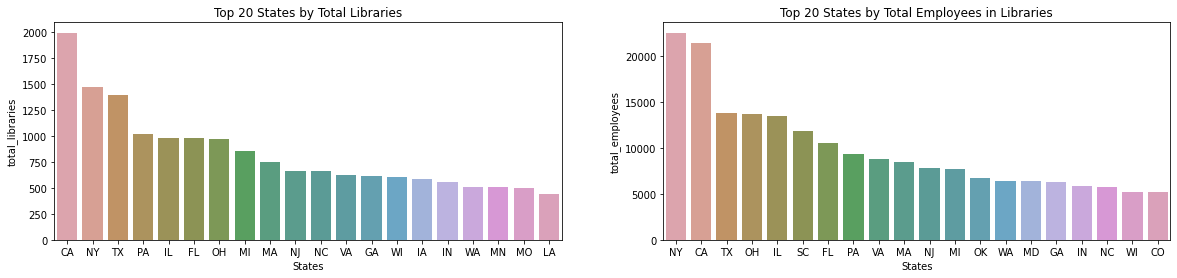

Text(0.5, 0, 'States')

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2,figsize=(20,4))

axes[0].set_title('Top 20 States by Total Libraries')
axes[1].set_title('Top 20 States by Total Employees in Libraries')

x = sns.barplot(ax=axes[0],x="STABB", y="total_libraries", data=top_20_states, saturation=.5)
x.set_xlabel("States")
x = sns.barplot(ax=axes[1],x="STABB", y="total_employees", data=top_20_states_emp, saturation=.5)
x.set_xlabel("States")

### Top 20 Libraries by Total locations

County of Los Angeles,  City of Los Angeles and Queens Borough Public Library are located in more than 50 locations across United States.

Out[46]:

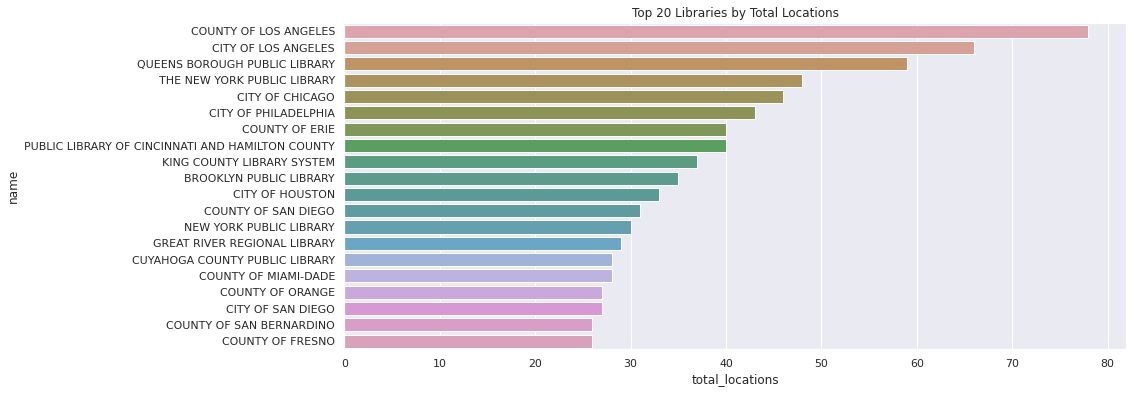

Text(0.5, 1.0, 'Top 20 Libraries by Total Locations')

In [0]:
sns.set(rc = {'figure.figsize':(14,6)})

sns.barplot(x="total_locations", y="name", data=top_20_by_libraries, saturation=.5,orient = 'h').set_title("Top 20 Libraries by Total Locations")

### Top 20 Libraries by Total Employees

State of California and University of Oklahoma employs each employ more than 5000 in library in United States which is largest in United States compared to any other libraries. But dont know why State of South carolina which present only at two locations in South carolina has so many employees in library. Spatial analysis after combining with other dataset may help in understanding this. But just from the point of interest dataset its not clear.

Out[47]:

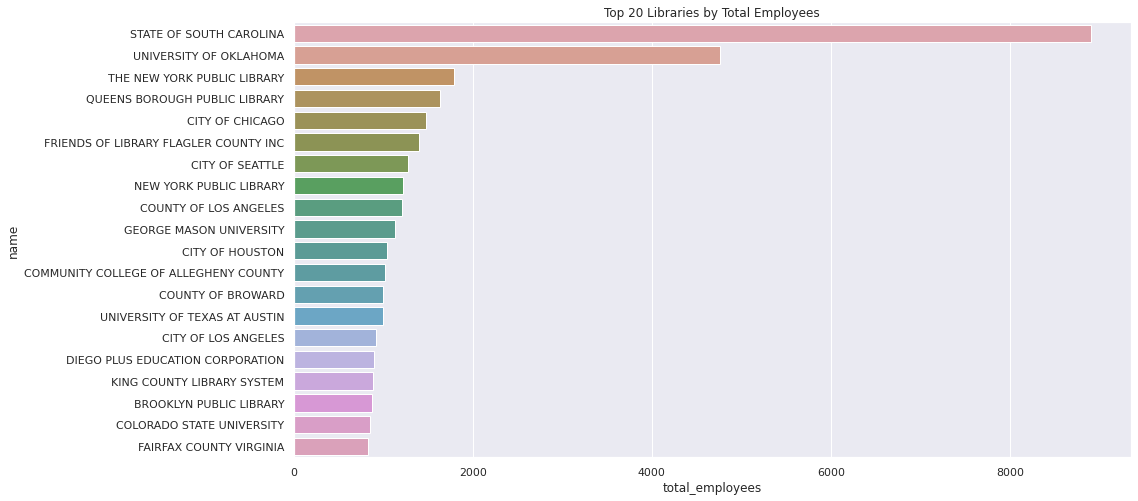

Text(0.5, 1.0, 'Top 20 Libraries by Total Employees')

In [0]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x="total_employees", y="name", data=top_20_by_libby_emp, saturation=.5,orient = 'h').set_title("Top 20 Libraries by Total Employees")

### Top 20 Libraries by Sales

CHEGG, UTAH STATE University and New York Public Library are top 3 libraries that generates revenue of more than USD 3 million. CHEGG being a topmost with more than 6m USD revenue indicates that this can be profit making business.

CHEGG physcially present only in California's one location but largest revenue maker

Out[53]:

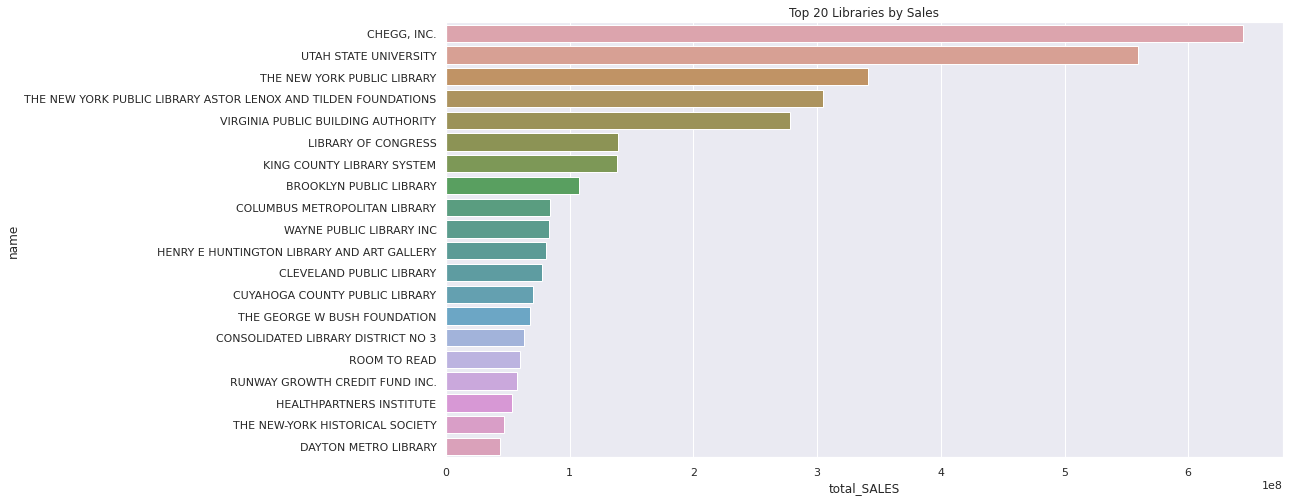

Text(0.5, 1.0, 'Top 20 Libraries by Sales')

In [0]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x="total_SALES", y="name", data=top_20_by_sales, saturation=.5,orient = 'h').set_title("Top 20 Libraries by Sales")


### Top 10 Libraries locations

This is how top 10 libraries by sales are distributed in different state. All top 10 libraries that generates highest revenue are physcially present only in one state. New york Public Library, Brooklyn Public Library, King county Public Library are present in more than 10 locations in same State. All apparently Prime Locations. But there is not much information available in the provided dataset on how they generate revenues, What services they provide etc. At this moment it is clear it is not necessary to be present in multiple locations to generate higher revenues.

It is not surprising to see that CHEGG present in only one location, but we know they provide lot of revenues from online educational services including study materials. Their presence is online as well as offline makes them more competitive and profitable.

Out[86]:

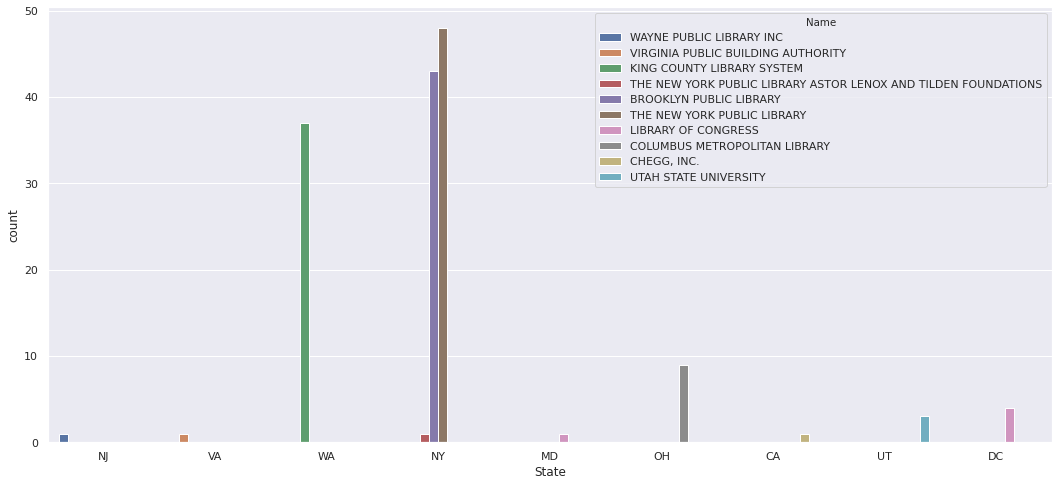

<matplotlib.axes._subplots.AxesSubplot at 0x7f177e501790>

In [0]:
sns.set(rc = {'figure.figsize':(18,8)})
sns.countplot(x="State", hue="Name", data=top_lib_by_state)


## Geo-Spatial analysis

This section shows Libraries across USA on the map. It gives nice visualization of all locations from the dataset.

### Library Map (All Libraries in USA)

Below map shows locations of all libraries from the dataset across USA. Libraries are located almost everywhere in United States. East cost has more number of libraries compared to West coast. As shown Top 3 Libraries (CHEGG, UTAH, NEW YORK Libraries) with highest earning/sales are from highly populated areas. These are also areas where standard of living is high compared to other locations. But high population may not be the sole reason for making so much profits compared to other libraries.

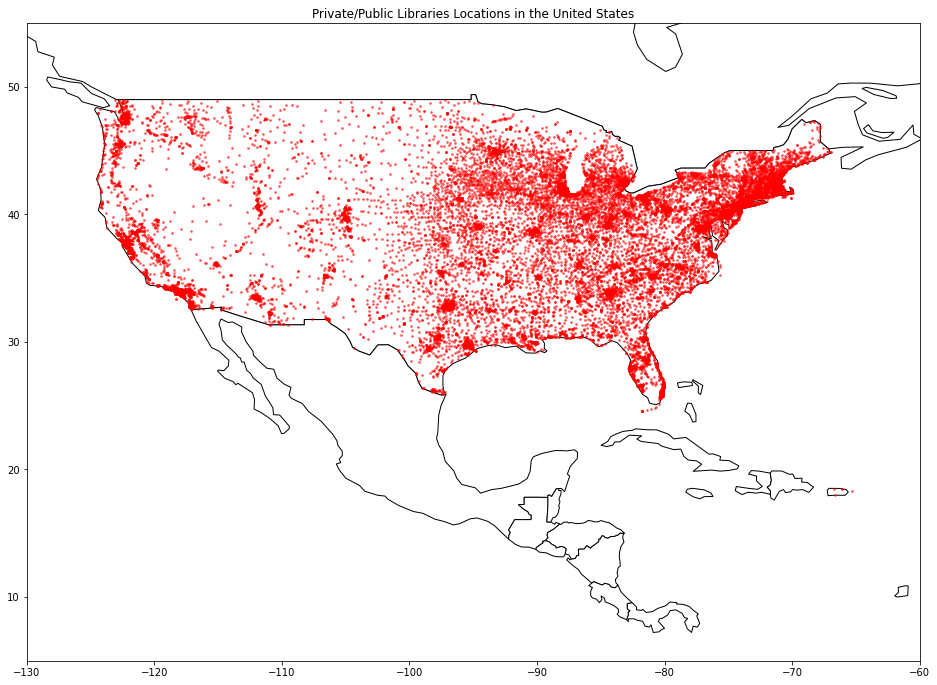

In [0]:
gdf = geopandas.GeoDataFrame(
    all_libraries, geometry=geopandas.points_from_xy(all_libraries.longitude, all_libraries.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(16,12))
gdf['color'] = gdf.employee_here

ax.set_xlim(-130, -60)
ax.set_ylim(5, 55)
gdf.plot(ax=ax, color='r', markersize=3, alpha=0.5)
plt.title('Private/Public Libraries Locations in the United States')
plt.show()

# Model Preparations

### Approach 1

Libraries dataset obtained in previous steps contains 23K libraries locations and with geofencing it locates all addreses within 5-10 mins from the libraries which aims to get demographic and audience expenditure details about potential consumers within travel boundary. This turns dataset to become huge and it was becoming time consuming to pull all possible addresses. This hackathon environment probably doesn't support that much memory and speed. Spark fails to load all possible records even for 100 libraries locations. Therefore Total libraries for modeling has been set limited to 50 libraries from Florida and loaded in delta table t_dis_poi_route50.

Following process followed to retrive all possible addresses for every library location.

 1.Run precisely functions to obtain polygon which contains all reachable locations from the library locations. 
 
 2.Run GeoSpatial function to convert all longitude/latititude in polygon field to PBKEY  which is actuall physical address
 
 3.This newly obtained table contains all possible addresses closer to library (5-10 mins). For 50 Libraries in Florida it has found total 700K addresses each with unique key PBKEY
 
 4.For the modeling this table joined with census table. 
 
Due to time limitation and also due to limitation of environment for the modeling purpose only census data shall be used. The model can be further improved by adding more information from other datasets like audience profile, family income/expenditure. they are useful features and may improve accuracy of the model later.
 
 
 Therefore This notebook is using Three tables
 1. t_dis_poi_route50
 2. gv_usa_population_census_by_001
 3. usa_address_fabric_001


Joined using PBKEY. Number of records further trimmed to 20K due to slowness.

### Approach 2

Second approch is as follows

1.For a given library address find all addresses within travel boundary with Preciesly Geo API

2.Take the average of numbers from census, audience profie, family income dataset from all addresses found within travel boundary

3.If required apply one hot encoding then also run Dimensionality reduction so eliminate redundant features.

This approach will make available all 23K libraries details for modeling. But due to huge data divide and conqure is required even after using Spark.

**Output variables**

 1.Employee_count
 
 2.sales_volume_us_dollars
 
These target variables to be used to make a decision whether given location is good for the business or not. Based on predicted sales and total number of employees required management can make a decision whether to invest in that location or not.
 
**Input variables**

  All other variables from both datasets.

**Algorithm**

This notebook uses Random forest with Multioutput regression using ScikitLearn Libarry.

### DataFrame

In [0]:

team5_library = spark.read.option("header","true").csv("/FileStore/discover/discover_modeling_ds01.csv").toPandas()

display(team5_library)

longitude latitude lat lon geoid prop_type employee_here employee_count year_start sales_volume_us_dollars family_members PBKEY CODE TYPE whtpopby blkpopby indpopby asnpopby hpipopby othpopby twopopby hsppopby nhpopby nhp1whtby nhp2blkby nhp3indby nhp4asnby nhp5hpiby nhp6othby nhp7twoby hsp1whtby hsp2blkby hsp3indby hsp4asnby hsp5hpiby hsp6othby hsp7twoby popby p0004by p0509by p1014by p1519by p2024by p2529by p3034by p3539by p4044by p4549by p5054by p5559by p6064by p6569by p7074by p7579by p8084by p85pby pmedby padultby pamedby p1819by maleby m0004by m0509by m1014by m1519by m2024by m2529by m3034by m3539by m4044by m4549by m5054by m5559by m6064by m6569by m7074by m7579by m8084by m85pby mmedby madultby mamedby m1819by femaleby f0004by f0509by f1014by f1519by f2024by f2529by f3034by f3539by f4044by f4549by f5054by f5559by f6064by f6569by f7074by f7579by f8084by f85pby fmedby fadultby famedby f1819by pop00by pop01by pop02by pop03by pop04by pop05by pop06by pop07by pop08by pop09by pop10by pop11by pop12by pop13by pop14by pop15by pop16by pop17by pop18by pop19by male00by male01by male02by male03by male04by male05by male06by male07by male08by male09by male10by male11by male12by male13by male14by male15by male16by male17by male18by male19by female00by female01by female02by female03by female04by female05by female06by female07by female08by female09by female10by female11by female12by female13by female14by female15by female16by female17by female18by female19by hhby hhpopby avghhszby gqpopby gq1insby gq2corby gq3juvby gq4nurby gq5oifby gq6nonby gq7colby gq8milby gq9onfby hhs1perby hhs2perby hhs3perby hhs4perby hhs5perby hhs6perby hhs7perby ls01p05pby ls02englby ls03spanby ls04frenby ls05frcrby ls06italby ls07portby ls08germby ls09yiddby ls10owgeby ls11scanby ls12greeby ls13russby ls14poliby ls15serbby ls16oslaby ls17armeby ls18persby ls19gujaby ls20hindby ls21urduby ls22oindby ls23oieuby ls24chinby ls25japaby ls26koreby ls27mocaby ls28hmonby ls29thaiby ls30loatby ls31vietby ls32oasnby ls33tagaby ls34opisby ls35navaby ls36onnaby ls37hungby ls38arabby ls39hebrby ls40afriby ls41otunby an01amerby an02arabby an03britby an04czecby an05daniby an06dutcby an07englby an08euroby an09frenby an10frcnby an11germby an12greeby an13hungby an14irisby an15italby an16lithby an17norwby an18poliby an19portby an20russby an21scirby an22scotby an23slovby an24safrby an25swedby an26swisby an27ukraby an28welsby an29windby an30othgby an31ucnrby -81.700241 30.161839 30.144859 -81.700116 120190307012001 R 4 4 1993 989272 0 P00005K4134D 120190307012 BG 1435 29 1 44 0 9 13 69 1462 1376 28 1 44 0 4 9 59 1 0 0 0 5 4 1531 39 50 77 109 88 49 43 62 73 130 174 151 133 86 55 62 53 97 51.5 1291 54.8 35 757 26 28 41 61 52 28 21 31 33 69 67 81 64 51 24 25 20 35 49.0 620 54.3 19 774 13 22 36 48 36 21 22 31 40 61 107 70 69 35 31 37 33 62 52.7 671 55.1 16 5 8 10 10 6 7 9 9 13 12 12 11 17 18 19 24 23 27 25 10 2 4 8 9 3 6 5 4 7 6 5 8 6 11 11 14 10 18 15 4 3 4 2 1 3 1 4 5 6 6 7 3 11 7 8 10 13 9 10 6 664 1531 2.31 0 0 0 0 0 0 0 0 0 0 188 249 113 79 23 9 3 1492 1437 15 0 0 3 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 3 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 183 0 0 1 3 13 191 23 42 3 191 4 3 165 74 0 21 49 2 7 32 20 0 0 8 0 0 0 0 210 286 -81.700241 30.161839 30.137492 -81.703691 120190307034004 R 4 4 1993 989272 0 P00005K41391 120190307034 BG 1554 126 6 100 2 39 50 164 1713 1468 107 5 98 2 0 33 86 19 1 2 0 39 17 1877 67 115 170 155 71 57 48 114 137 218 154 137 138 96 73 53 39 35 45.1 1418 50.5 48 923 32 69 91 70 40 27 24 53 59 101 81 63 66 44 36 28 14 25 44.8 686 50.9 25 954 35 46 79 85 31 30 24 61 78 117 73 74 72 52 37 25 25 10 45.4 732 50.1 23 8 16 13 13 17 15 25 22 20 33 33 25 48 33 31 31 46 30 26 22 4 3 7 9 9 7 19 14 10 19 15 14 27 16 19 14 17 14 11 14 4 13 6 4 8 8 6 8 10 14 18 11 21 17 12 17 29 16 15 8 698 1877 2.69 0 0 0 0 0 0 0 0 0 0 104 295 118 112 47 14 8 1810 1651 54 13 21 6 0 12 0 0 14 0 0 7 0 0 0 0 0 0 0 0 0 6 3 0 0 0 7 0 0 0 11 5 0 0 0 0 0 0 0 133 5 37 2 1 16 149 25 65 4 269 0 0 180 96 13 16 55 2 

In [0]:
t5lib_ds.shape

Out[18]: (48, 246)

### Total Features

This dataframe as total 254 features. ALl are numerical features with no missing values. Only PBKEY, CODE and TYPE are categorical which are removed from the analysis for this notebook.

In [0]:
team5_library.info()
print('')
print('Feature Names are : ')
print('')
print(team5_library.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 258 entries, longitude to an31ucnrby
dtypes: object(258)
memory usage: 37.9+ MB

Feature Names are : 

Index(['longitude', 'latitude', 'lat', 'lon', 'geoid', 'prop_type',
 'employee_here', 'employee_count', 'year_start',
 'sales_volume_us_dollars',
 ...
 'an22scotby', 'an23slovby', 'an24safrby', 'an25swedby', 'an26swisby',
 'an27ukraby', 'an28welsby', 'an29windby', 'an30othgby', 'an31ucnrby'],
 dtype='object', length=258)

### Target variables

There are two numeric target variables as follows:

1.employee count - employees required at this location

2.Sales in US Dollars. Convert it into units of 1 million.

In [0]:
target = team5_library.loc[:,['employee_count','sales_volume_us_dollars']]

target['employee_count']          = target['employee_count'].astype(int)
target['sales_volume_us_dollars'] = target['sales_volume_us_dollars'].astype(float)
target['sales_volume_us_dollars'] = target['sales_volume_us_dollars']/1000000
target

Out[4]:

employee_count 
 sales_volume_us_dollars 
 
 
 
 
 0 
 4 
 0.989272 
 
 
 1 
 4 
 0.989272 
 
 
 2 
 5 
 0.500000 
 
 
 3 
 5 
 0.500000 
 
 
 4 
 5 
 0.500000 
 
 
 ... 
 ... 
 ... 
 
 
 19234 
 16 
 0.747774 
 
 
 19235 
 16 
 0.747774 
 
 
 19236 
 16 
 0.747774 
 
 
 19237 
 11 
 0.436909 
 
 
 19238 
 11 
 0.436909 
 
 
 
 19239 rows × 2 columns

###  Remove features
Remove following feaures from original dataset categorical features  PBKEY, CODE and TYPE as mentioned in the previous step

These are unique keys/foreign keys not required in modeling.

1.PBKEY

2.CODE

3.TYPE

4.employee_count (target feature)

5.sales_volume_us_dollars (target feature)

6.Longitude (Libraries)

7.Latitude  (Libraries)

8.geoid

In [0]:
discover05_ds = team5_library.loc[:,~team5_library.columns.isin(['PBKEY', 'CODE','TYPE','longitude','latitude','geoid','employee_count','sales_volume_us_dollars'])].copy()
discover05_ds

Out[5]:

lat 
 lon 
 prop_type 
 employee_here 
 year_start 
 family_members 
 whtpopby 
 blkpopby 
 indpopby 
 asnpopby 
 hpipopby 
 othpopby 
 twopopby 
 hsppopby 
 nhpopby 
 nhp1whtby 
 nhp2blkby 
 nhp3indby 
 nhp4asnby 
 nhp5hpiby 
 nhp6othby 
 nhp7twoby 
 hsp1whtby 
 hsp2blkby 
 hsp3indby 
 hsp4asnby 
 hsp5hpiby 
 hsp6othby 
 hsp7twoby 
 popby 
 p0004by 
 p0509by 
 p1014by 
 p1519by 
 p2024by 
 p2529by 
 p3034by 
 p3539by 
 p4044by 
 p4549by 
 ... 
 ls33tagaby 
 ls34opisby 
 ls35navaby 
 ls36onnaby 
 ls37hungby 
 ls38arabby 
 ls39hebrby 
 ls40afriby 
 ls41otunby 
 an01amerby 
 an02arabby 
 an03britby 
 an04czecby 
 an05daniby 
 an06dutcby 
 an07englby 
 an08euroby 
 an09frenby 
 an10frcnby 
 an11germby 
 an12greeby 
 an13hungby 
 an14irisby 
 an15italby 
 an16lithby 
 an17norwby 
 an18poliby 
 an19portby 
 an20russby 
 an21scirby 
 an22scotby 
 an23slovby 
 an24safrby 
 an25swedby 
 an26swisby 
 an27ukraby 
 an28welsby 
 an29windby 
 an30othgby 
 an31ucnrby 
 
 
 
 
 0 
 30.144859 
 -81.700116 
 R 
 4 
 1993 
 0 
 1435 
 29 
 1 
 44 
 0 
 9 
 13 
 69 
 1462 
 1376 
 28 
 1 
 44 
 0 
 4 
 9 
 59 
 1 
 0 
 0 
 0 
 5 
 4 
 1531 
 39 
 50 
 77 
 109 
 88 
 49 
 43 
 62 
 73 
 130 
 ... 
 2 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 183 
 0 
 0 
 1 
 3 
 13 
 191 
 23 
 42 
 3 
 191 
 4 
 3 
 165 
 74 
 0 
 21 
 49 
 2 
 7 
 32 
 20 
 0 
 0 
 8 
 0 
 0 
 0 
 0 
 210 
 286 
 
 
 1 
 30.137492 
 -81.703691 
 R 
 4 
 1993 
 0 
 1554 
 126 
 6 
 100 
 2 
 39 
 50 
 164 
 1713 
 1468 
 107 
 5 
 98 
 2 
 0 
 33 
 86 
 19 
 1 
 2 
 0 
 39 
 17 
 1877 
 67 
 115 
 170 
 155 
 71 
 57 
 48 
 114 
 137 
 218 
 ... 
 11 
 5 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 133 
 5 
 37 
 2 
 1 
 16 
 149 
 25 
 65 
 4 
 269 
 0 
 0 
 180 
 96 
 13 
 16 
 55 
 2 
 19 
 11 
 65 
 8 
 0 
 29 
 2 
 1 
 32 
 33 
 339 
 270 
 
 
 2 
 30.023334 
 -82.352214 
 R 
 5 
 1997 
 0 
 968 
 250 
 13 
 4 
 1 
 10 
 35 
 40 
 1241 
 956 
 240 
 13 
 4 
 1 
 0 
 27 
 12 
 10 
 0 
 0 
 0 
 10 
 8 
 1281 
 111 
 100 
 130 
 98 
 64 
 93 
 88 
 94 
 71 
 92 
 ... 
 0 
 0 
 0 
 2 
 0 
 0 
 1 
 5 
 0 
 99 
 2 
 5 
 1 
 0 
 22 
 136 
 5 
 40 
 3 
 78 
 2 
 0 
 100 
 15 
 3 
 7 
 3 
 2 
 0 
 15 
 28 
 0 
 50 
 4 
 0 
 0 
 2 
 10 
 362 
 287 
 
 
 3 
 30.021502 
 -82.346947 
 R 
 5 
 1997 
 0 
 968 
 250 
 13 
 4 
 1 
 10 
 35 
 40 
 1241 
 956 
 240 
 13 
 4 
 1 
 0 
 27 
 12 
 10 
 0 
 0 
 0 
 10 
 8 
 1281 
 111 
 100 
 130 
 98 
 64 
 93 
 88 
 94 
 71 
 92 
 ... 
 0 
 0 
 0 
 2 
 0 
 0 
 1 
 5 
 0 
 99 
 2 
 5 
 1 
 0 
 22 
 136 
 5 
 40 
 3 
 78 
 2 
 0 
 100 
 15 
 3 
 7 
 3 
 2 
 0 
 15 
 28 
 0 
 50 
 4 
 0 
 0 
 2 
 10 
 362 
 287 
 
 
 4 
 30.02282 
 -82.343346 
 B 
 5 
 1997 
 0 
 843 
 66 
 2 
 5 
 0 
 12 
 15 
 52 
 891 
 807 
 66 
 2 
 5 
 0 
 0 
 11 
 36 
 0 
 0 
 0 
 0 
 12 
 4 
 943 
 69 
 71 
 53 
 65 
 52 
 64 
 48 
 67 
 55 
 81 
 ... 
 0 
 0 
 0 
 1 
 0 
 0 
 1 
 4 
 0 
 73 
 1 
 4 
 1 
 0 
 16 
 100 
 3 
 29 
 2 
 58 
 1 
 0 
 74 
 11 
 2 
 5 
 2 
 1 
 0 
 11 
 21 
 0 
 37 
 3 
 0 
 0 
 1 
 9 
 267 
 211 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 19234 
 30.530609 
 -86.472048 
 R 
 16 
 1975 
 0 
 659 
 45 
 4 
 29 
 1 
 21 
 43 
 80 
 722 
 608 
 45 
 4 
 29 
 1 
 2 
 33 
 51 
 0 
 0 
 0 
 0 
 19 
 10 
 802 
 58 
 48 
 36 
 66 
 92 
 86 
 64 
 45 
 48 
 66 
 ... 
 5 
 2 
 0 
 0 
 2 
 0 
 0 
 0 
 0 
 91 
 0 
 7 
 7 
 0 
 13 
 90 
 10 
 29 
 9 
 104 
 4 
 5 
 91 
 36 
 1 
 8 
 24 
 0 
 1 
 20 
 17 
 0 
 0 
 3 
 3 
 5 
 11 
 4 
 123 
 86 
 
 
 19235 
 30.530334 
 -86.472052 
 R 
 16 
 1975 
 0 
 659 
 45 
 4 
 29 
 1 
 21 
 43

In [0]:
discover05_ds.prop_type.unique()

Out[5]: array(['R', 'B', 'X', 'V', 'M'], dtype=object)

###  Data types

Dataframe info show that all features are of type object. This dataset has prop_type a categorical feature all other are numerical. So all data type of all variables needs to be set to numeric.

1.Keep prop_type as object

2.Convert these variables from object to float - 'prop_type','lat','lon','pamedby','pmedby','mmedby','mamedby','fmedby','famedby','avghhszby'

3.Convert all other variables to int from object

In [0]:
discover05_ds['lat']   = discover05_ds['lat'].astype(float)
discover05_ds['lon']   = discover05_ds['lon'].astype(float)
discover05_ds['pamedby']   = discover05_ds['pamedby'].astype(float)
discover05_ds['pmedby']    = discover05_ds['pmedby'].astype(float)
discover05_ds['mmedby']    = discover05_ds['mmedby'].astype(float)
discover05_ds['mamedby']   = discover05_ds['mamedby'].astype(float)
discover05_ds['fmedby']    = discover05_ds['fmedby'].astype(float)
discover05_ds['famedby']   = discover05_ds['famedby'].astype(float)
discover05_ds['avghhszby'] = discover05_ds['avghhszby'].astype(float)

for i,col in enumerate(discover05_ds.columns):
       if col not in ['prop_type','lat','lon','pamedby','pmedby','mmedby','mamedby','fmedby','famedby','avghhszby']: 
          discover05_ds[col] = discover05_ds[col].astype('int')

discover05_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 250 entries, lat to an31ucnrby
dtypes: float64(9), int64(240), object(1)
memory usage: 36.7+ MB

# Model Building and Evaluations

### Train/Test Split

Split data 90/10 into train and test.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    discover05_ds, target, test_size=0.1, random_state=42)

In [0]:
print('Target Train variable: ')
print(y_train)
print('')
print('Target Test variable: ')
print(y_test)

Target Train variable: 
 employee_count sales_volume_us_dollars
15194 16 0.747774
18745 48 1.341873
9504 11 0.436909
3511 4 0.989272
9722 11 0.436909
... ... ...
11284 11 0.436909
11964 21 0.880788
5390 4 0.989272
860 16 0.747774
15795 16 0.747774

[17315 rows x 2 columns]

Target Test variable: 
 employee_count sales_volume_us_dollars
12650 11 0.436909
17324 11 0.436909
18776 11 0.436909
12807 48 1.341873
12658 11 0.436909
... ... ...
8687 48 1.341873
4848 4 0.989272
8187 11 0.436909
1023 11 0.436909
5980 21 0.880788

[1924 rows x 2 columns]

### One Hot Encoding

Property type is Ordinal categorical feature. This feature can be useful and should be kept in the model. So one hot encoding is applied to convert it into numeric feaure. OneHot Encoder converts X_train set to sparse matrix. Which can still be used as input to random forest regressor.

In [0]:
enc = OneHotEncoder(handle_unknown='ignore')

Xtrain_Sparse = enc.fit_transform(X_train)
print(' ')
print('Shape of Training Set')
print(Xtrain_Sparse.shape)
Xtest_Sparse = enc.transform(X_test)
print(' ')
print('Shape of Test Set')
print(Xtest_Sparse.shape)


Shape of Training Set
(17315, 20599)
 
Shape of Test Set
(1924, 20599)

### Random forest model

There are lots of features that are being used for the modeling. All are in different scales. Therefore trying random forest model which doesn't need data to be normalized. Here 10 fold cross validation is used to evaluated model. Random forest inherently supports multiple output and suitable for hackthon problem.

In [0]:
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(max_depth=5, random_state=0)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, Xtrain_Sparse, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores

RMSE: 0.027 (0.039)
Out[12]: array([1.28526922e-02, 1.88113841e-02, 1.75605384e-02, 5.41635796e-03,
 2.28257414e-02, 4.55270999e-15, 1.30511982e-02, 2.05561117e-02,
 1.44698040e-02, 1.45477157e-01, 1.83779848e-02, 1.47594232e-02,
 1.40269692e-01, 1.89497686e-02, 8.70811596e-03, 1.82493033e-02,
 5.79537992e-03, 1.75301376e-02, 1.31970138e-02, 1.21240766e-02,
 1.38823218e-02, 1.59178903e-02, 5.73948974e-03, 2.25237838e-02,
 1.41159210e-01, 4.67207729e-15, 1.71848853e-02, 1.13500536e-02,
 1.61241971e-02, 1.73120795e-02])

In [0]:
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(RandomForestRegressor(max_depth=5, random_state=0)).fit(Xtrain_Sparse, y_train)
y_pred=clf.predict(Xtest_Sparse)

### Actual Values Vs Predicted Values

Here is prediction using Random forest regressor. As shown in below output predicted values are almost matching for all test values. Indicating that model is working fine.

In [0]:
for index in range(y_test.shape[0]):
    print('Row : ', index,' :   ',y_test.values[index][0],',',y_test.values[index][1],'|',y_pred[index][0],',',y_pred[index][1])

Row : 0 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 1 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 2 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 3 : 48.0 , 1.341873 | 48.0 , 1.3418729999999977
Row : 4 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 5 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 6 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 7 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 8 : 48.0 , 1.341873 | 48.0 , 1.341872999999997
Row : 9 : 48.0 , 1.341873 | 48.0 , 1.3418729999999977
Row : 10 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 11 : 48.0 , 1.341873 | 48.0 , 1.341872999999997
Row : 12 : 48.0 , 1.341873 | 48.0 , 1.341872999999997
Row : 13 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 14 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 15 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 16 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 17 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 18 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 19 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 20 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 21 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 22 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 23 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 24 : 48.0 , 1.341873 | 48.0 , 1.341872999999997
Row : 25 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 26 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 27 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 28 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 29 : 5.0 , 0.5 | 5.0 , 0.5
Row : 30 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 31 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 32 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 33 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 34 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 35 : 11.0 , 0.436909 | 11.0 , 0.43690900000001176
Row : 36 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 37 : 48.0 , 1.341873 | 48.0 , 1.341872999999997
Row : 38 : 11.0 , 0.436909 | 11.0 , 0.43690900000001176
Row : 39 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 40 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 41 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 42 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 43 : 48.0 , 1.341873 | 48.0 , 1.3418729999999965
Row : 44 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 45 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 46 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 47 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 48 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 49 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 50 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 51 : 21.0 , 0.880788 | 21.0 , 0.8807879999999821
Row : 52 : 5.0 , 0.5 | 5.0 , 0.5
Row : 53 : 48.0 , 1.341873 | 48.0 , 1.341872999999997
Row : 54 : 48.0 , 1.341873 | 48.0 , 1.3418729999999968
Row : 55 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 56 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 57 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 58 : 48.0 , 1.341873 | 48.0 , 1.3418729999999974
Row : 59 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 60 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 61 : 48.0 , 1.341873 | 48.0 , 1.3418729999999968
Row : 62 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 63 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 64 : 4.0 , 0.989272 | 4.0 , 0.989272000000017
Row : 65 : 48.0 , 1.341873 | 48.0 , 1.3418729999999977
Row : 66 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 67 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 68 : 48.0 , 1.341873 | 48.0 , 1.3418729999999974
Row : 69 : 48.0 , 1.341873 | 48.0 , 1.3418729999999974
Row : 70 : 16.0 , 0.747774 | 16.0 , 0.747774
Row : 71 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 72 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 73 : 11.0 , 0.436909 | 11.0 , 0.43690900000001187
Row : 74 : 16.0 , 0.747774 | 16.0 , 0.747774
Row 

## Approach 2 

This approach takes average values from census data for locations found in polygon by precisely dataset. This way this dataset contains 214 libraries out of 23K libraries. However, Below result indicates that for better predictive capability more records needs to be included in the dataset. Below model is only for demonstrative purpose. 

Code for pulling data is available in another notebook (Prepare_AddressData_v02.ipynb on the github)

In [0]:
libraries_df =  spark.sql("select pb_key,employee_here,employee_count,sales_volume_us_dollars/1000000 sales_volume_us_dollars,family_members from t_dis_boundary00 union select pb_key,employee_here,employee_count,sales_volume_us_dollars/1000000 sales_volume_us_dollars,family_members from t_dis_boundary01 union select pb_key,employee_here,employee_count,sales_volume_us_dollars/1000000 sales_volume_us_dollars,family_members from t_dis_boundary02 union select pb_key,employee_here,employee_count,sales_volume_us_dollars/1000000 sales_volume_us_dollars,family_members from t_dis_boundary03 union select pb_key,employee_here,employee_count,sales_volume_us_dollars/1000000 sales_volume_us_dollars,family_members from t_dis_boundary04 union select pb_key,employee_here,employee_count,sales_volume_us_dollars/1000000 sales_volume_us_dollars,family_members from t_dis_boundary05").toPandas()

display(libraries_df)

pb_key employee_here employee_count sales_volume_us_dollars family_members P0000M3IJK9N 53 53 16.678485 0 P00002T66L5Q 150 150 36.192438 0 P00007UTKASO 119 119 8.569004 0 P0000FNZ2UUS 8 8 38.650248 0 P0000NH5RQVV 3 3 278.135336 0 null 88 88 11.303437 0 P00007UUPE53 65 65 8.676981 0 P0000BJ4UMV4 376 376 14.163352 0 P00007UUAIXO 16 16 10.422706 0 P0000FNYZ1JP 30 30 83.0 0 P00007UTDX45 99 99 16.030302 0 P00002SX9FBT 3 3 80.670234 0 P0000GL20B50 4 4 40.288659 0 P00002SX9FBT 380 380 21.863208 0 P0000BJ4UG4X 56 56 9.619786 0 P0000GL1AGZ0 150 150 46.956545 0 P0000EACGOMW 3 3 9.292802 0 P00009OZAPPC 90 90 12.537155 0 P00002SVXNVH 25 25 13.999827 0 P000046IS49A 86 86 11.63657 0 P00007UT01KW 250 250 13.908626 0 P00003PZ08C5 1 1 22.321009 275 P0000M3K7372 3 3 10.716 0 P00007UWDIPK 3 3 57.626303 0 P00002T0XUGP 900 900 30.801243 0 P0000EQVRA81 1 1 22.01038 0 P0000BJ5PZJJ 5 5 8.70889 0 P0000B2KZWLO 360 360 24.000914 65930 P0000BZQ614U 99 99 8.502746 0 P00008BCAVHU 105 105 38.28377 0 P00007UWDQYE 115 115 33.61735 0 P0000BJ4THMP 53 53 11.085396 0 P000098FOIXO 2 2 12.084428 0 P0000CG7EQFB 112 112 53.759 141 P0000B2LQ2PM 99 99 27.790725 0 P0000GL5UUZN 72 72 305.032569 0 P000060Q91O9 3 3 27.96532 0 P00008BD15DP 3 3 36.167665 0 P00007UT9VML 100 100 7.725078 0 P0000JCB09BL 4 4 14.40233 0 P0000HYNJJ59 12 12 84.275564 0 P00002T1LAVL 4 4 16.981973 0 P000046IQTHB 38 38 7.753522 0 P0000HYOR75M 3 3 13.728178 0 P00008RVU2CP 3 3 15.429721 0 P0000BZP1PWZ 20 20 29.114653 0 P0000PB9XKS1 12 12 9.923168 0 P0000DDAPGWG 3 3 7.502062 0 P00008BCF4AB 43 43 7.920247 0 P0000GL154VJ 39 39 8.541175 0 P0000HYNB00T 83 83 5.390157 0 P0000GL4CBJ9 38 38 5.219316 0 P00005K8NBVN 35 35 7.0 0 P0000B2LGASC 45 45 5.916613 0 P0000BZP5FGF 3 3 6.042355 0 P0000DDO9W6B 5 5 4.927499 0 P00007UT2YHW 80 80 7.141328 0 P00007USXZGR 91 91 5.23024 0 P0000JCBUB96 18 18 5.157934 0 P0000B2KSGFI 19 19 6.329129 0 P0000GL3WGFT 140 140 5.075051 0 P00005K80PQN 11 11 6.911534 0 P000053KV4FG 17 17 5.364513 65930 P0000GL3R96N 52 52 5.920545 0 P00007VMO13D 94 94 7.121517 0 P000053KUA5L 5 5 5.451288 0 P0000GL3DVMZ 45 45 6.853725 0 P00007E9YOCQ 18 18 6.402722 0 P0000GL3RB3N 52 52 4.435665 0 P000046IQGQM 58 58 5.901766 0 P0000GL3ZISG 3 3 5.266159 0 P0000GL3M7GK 61 61 5.328275 0 P0000M3LHN7E 42 42 4.826987 0 P00007V7S8BD 8 8 5.247245 0 P0000GL283R3 26 26 4.882742 0 P00007UUAYT9 38 38 6.940121 0 P0000GL29D2J 90 90 5.352974 0 P00007UTYKBH 100 100 6.415582 0 P00007UUZS3N 105 105 6.884659 0 P0000EAC6N21 3 3 4.660506 0 P0000GL20FAG 60 60 4.587447 0 P0000GL3MRDK 139 139 4.980999 0 P0000GL2A14O 100 100 5.161093 0 P00007UWBQSY 80 80 6.466446 0 P0000BZQ5Y03 100 100 4.828404 0 P0000GL27I3F 3 3 5.619384 0 P0000K9CDB7G 4 4 4.653214 0 null 34 34 4.5 0 P00007E9Q70L 5 5 5.834723 0 P0000JC9KBRH 14 14 4.80899 0 P0000GL3G0C1 36 36 5.072938 0 P00007UTX18A 96 96 4.536254 0 P0000K9C7DX0 63 63 5.67565 0 P0000GL3K2PR 98 98 6.387686 0 P0000BJ5F17Q 3 3 4.842485 0 P00002SVW6XL 99 99 5.41003 0 P00007UT4Y8H 47 47 5.222531 0 P0000CG7BQ65 24 24 4.856099 0 P0000GL3FVK6 83 83 4.574499 0 P0000EACFKEB 120 120 6.561546 0 P00007UUZ2CM 30 30 4.348028 0 P000046ISOI6 45 45 3.582528 0 P0000GL3E7C8 107 107 3.481515 0 P0000CWQX23V 14 14 3.743147 0 P0000BZPIT4L 90 90 4.011767 0 P0000M3OMLS5 3 3 4.32846 0 P0000K9C5NSZ 35 35 3.932829 0 P0000GL3ZOA0 50 50 3.681468 0 P00007UT4GI3 99 99 4.414261 0 P00008BDG15L 10 10 4.387017 0 P0000DDB7C72 3 3 3.520549 0 null 3 3 3.519514 0 P0000GL3T23G 85 85 3.659128 0 P0000CG80F2J 13 13 3.401961 0 P0000BJ5RUSE 2 2 3.579116 0 P0000GL43JLH 3 3 4.426433 0 P0000GL43VX9 90 90 3.98252 0 P0000KPVSAYK 10 10 3.48701 0 P0000JCATMTG 25 25 3.870498 0 P0000M3NMDO3 3 3 4.192505 0 P0000GL4J0AP 80 80 4.203626 82 P0000GL3NLFE 75 75 4.0 0 P0000PB9WMO6 11 11 3.830518 0 P0000GL3CMHU 100 100 3.788684 0 P0000HYOQCSN 55 55 3.857695 0 P00005K5E184 50 50 3.427276 0 P0000BZOHZT6 40 40 3.54195 0 P0000HYOH6PG 75 75 3.496946 0 P00007UTBXFE 63 63 3.565691 0 P00009OZFTOW 19 19 3.952827 0 P0000FNYIGU3 57 57 4.311093 0 P00007UTH6OO 50 50 4.015762 0 P00

In [0]:
import pandas as pd
t5lib_ds00 = spark.read.option("header","true").csv("/blueprint-hackathon/discover/censusdbfs/census_mean_0000").toPandas()
t5lib_ds01 = spark.read.option("header","true").csv("/blueprint-hackathon/discover/censusdbfs/census_mean_0001").toPandas()
t5lib_ds02 = spark.read.option("header","true").csv("/blueprint-hackathon/discover/censusdbfs/census_mean_0002").toPandas()
t5lib_ds03 = spark.read.option("header","true").csv("/blueprint-hackathon/discover/censusdbfs/census_mean_0003").toPandas()
t5lib_ds04 = spark.read.option("header","true").csv("/blueprint-hackathon/discover/censusdbfs/census_mean_0004").toPandas()
t5lib_ds05 = spark.read.option("header","true").csv("/blueprint-hackathon/discover/censusdbfs/census_mean_0005").toPandas()

merge = [t5lib_ds00,t5lib_ds01,t5lib_ds02,t5lib_ds03,t5lib_ds04,t5lib_ds05]

t5lib_ds = pd.concat(merge)

t5lib_ds = t5lib_ds.rename(columns={"PB_KEY": "pb_key"})
display(t5lib_ds)

pb_key CODE whtpopby blkpopby indpopby asnpopby hpipopby othpopby twopopby hsppopby nhpopby nhp1whtby nhp2blkby nhp3indby nhp4asnby nhp5hpiby nhp6othby nhp7twoby hsp1whtby hsp2blkby hsp3indby hsp4asnby hsp5hpiby hsp6othby hsp7twoby popby p0004by p0509by p1014by p1519by p2024by p2529by p3034by p3539by p4044by p4549by p5054by p5559by p6064by p6569by p7074by p7579by p8084by p85pby pmedby padultby pamedby p1819by maleby m0004by m0509by m1014by m1519by m2024by m2529by m3034by m3539by m4044by m4549by m5054by m5559by m6064by m6569by m7074by m7579by m8084by m85pby mmedby madultby mamedby m1819by femaleby f0004by f0509by f1014by f1519by f2024by f2529by f3034by f3539by f4044by f4549by f5054by f5559by f6064by f6569by f7074by f7579by f8084by f85pby fmedby fadultby famedby f1819by pop00by pop01by pop02by pop03by pop04by pop05by pop06by pop07by pop08by pop09by pop10by pop11by pop12by pop13by pop14by pop15by pop16by pop17by pop18by pop19by male00by male01by male02by male03by male04by male05by male06by male07by male08by male09by male10by male11by male12by male13by male14by male15by male16by male17by male18by male19by female00by female01by female02by female03by female04by female05by female06by female07by female08by female09by female10by female11by female12by female13by female14by female15by female16by female17by female18by female19by hhby hhpopby avghhszby gqpopby gq1insby gq2corby gq3juvby gq4nurby gq5oifby gq6nonby gq7colby gq8milby gq9onfby hhs1perby hhs2perby hhs3perby hhs4perby hhs5perby hhs6perby hhs7perby ls01p05pby ls02englby ls03spanby ls04frenby ls05frcrby ls06italby ls07portby ls08germby ls09yiddby ls10owgeby ls11scanby ls12greeby ls13russby ls14poliby ls15serbby ls16oslaby ls17armeby ls18persby ls19gujaby ls20hindby ls21urduby ls22oindby ls23oieuby ls24chinby ls25japaby ls26koreby ls27mocaby ls28hmonby ls29thaiby ls30loatby ls31vietby ls32oasnby ls33tagaby ls34opisby ls35navaby ls36onnaby ls37hungby ls38arabby ls39hebrby ls40afriby ls41otunby an01amerby an02arabby an03britby an04czecby an05daniby an06dutcby an07englby an08euroby an09frenby an10frcnby an11germby an12greeby an13hungby an14irisby an15italby an16lithby an17norwby an18poliby an19portby an20russby an21scirby an22scotby an23slovby an24safrby an25swedby an26swisby an27ukraby an28welsby an29windby an30othgby an31ucnrby P00007UTKASO 1.7089852223366644E11 1542.0517623020603 78.15630853056359 4.73165332879278 54.73625063851524 0.9749702026221693 109.02571088029967 34.883024008172995 279.22697088370506 1545.3327090073217 1394.8659969351268 73.98092967818832 2.0590839434701174 53.66099097565129 0.7430614677336965 0.7808615698961349 19.241784437255237 147.18576536693342 4.175378852375276 2.672569385322663 1.0752596628639537 0.23190873488847266 108.24484931040354 15.64123957091776 1824.5596798910267 113.44747147965265 123.54452579601566 117.91145922016005 142.75174527498723 122.67835859015835 149.600374595607 125.10471649923379 135.68108292184573 134.0640217946535 136.1205516771667 123.51745274987229 108.52000681082922 91.1288949429593 63.35399284862932 45.92014302741359 31.814915715988423 28.386344287416993 31.013621658436914 38.368636131449556 1371.8777456155287 45.70621488166442 44.97326749531756 957.7566831261706 59.12702196492423 62.368465860718544 61.64685850502298 90.53396901072706 72.93887280776434 86.2353141494977 68.47999318917078 73.71513706793802 69.86804018389239 69.7086667801805 63.6388557806913 55.02860548271752 44.280946705261364 27.69828026562234 20.95624042227141 11.815085986718882 10.31466030989273 9.401668653158522 36.85448663374836 711.7270560190703 44.35082581304133 27.646688234292526 866.8029967648562 54.320449514728416 61.176059935297125 56.26460071513707 52.21777626426017 49.739485782394006 63.36506044610931 56.624723310063 61.96594585390771 64.19598161076111 66.41188489698621 59.878596969181 53.4914013281117 46.84794823769794 35.65571258300698 24.963902605142177 19.99982972926954 18.071683977524263 21.611953005278394 40.14445768772498 660.1506895964584 47

In [0]:
result_df = pd.merge(libraries_df, t5lib_ds, how="inner", on=["pb_key"])
result_df

Out[28]:

pb_key 
 employee_here 
 employee_count 
 sales_volume_us_dollars 
 family_members 
 CODE 
 whtpopby 
 blkpopby 
 indpopby 
 asnpopby 
 hpipopby 
 othpopby 
 twopopby 
 hsppopby 
 nhpopby 
 nhp1whtby 
 nhp2blkby 
 nhp3indby 
 nhp4asnby 
 nhp5hpiby 
 nhp6othby 
 nhp7twoby 
 hsp1whtby 
 hsp2blkby 
 hsp3indby 
 hsp4asnby 
 hsp5hpiby 
 hsp6othby 
 hsp7twoby 
 popby 
 p0004by 
 p0509by 
 p1014by 
 p1519by 
 p2024by 
 p2529by 
 p3034by 
 p3539by 
 p4044by 
 p4549by 
 ... 
 ls33tagaby 
 ls34opisby 
 ls35navaby 
 ls36onnaby 
 ls37hungby 
 ls38arabby 
 ls39hebrby 
 ls40afriby 
 ls41otunby 
 an01amerby 
 an02arabby 
 an03britby 
 an04czecby 
 an05daniby 
 an06dutcby 
 an07englby 
 an08euroby 
 an09frenby 
 an10frcnby 
 an11germby 
 an12greeby 
 an13hungby 
 an14irisby 
 an15italby 
 an16lithby 
 an17norwby 
 an18poliby 
 an19portby 
 an20russby 
 an21scirby 
 an22scotby 
 an23slovby 
 an24safrby 
 an25swedby 
 an26swisby 
 an27ukraby 
 an28welsby 
 an29windby 
 an30othgby 
 an31ucnrby 
 
 
 
 
 0 
 P0000M3IJK9N 
 53 
 53 
 16.678485 
 0 
 4.811301259921558E11 
 851.6868075385494 
 204.9170378831144 
 8.440281743765468 
 86.63578907291071 
 0.6997905958499905 
 243.48695983247669 
 42.071692366266895 
 532.6539501237388 
 905.2844089091948 
 589.0942318675043 
 198.80205596801827 
 4.051741861793261 
 86.02825052351038 
 0.6040738625547306 
 4.475994669712545 
 22.228060156101275 
 262.5925756710451 
 6.114981915096136 
 4.388539881972206 
 0.6075385494003427 
 0.09571673329525986 
 239.01096516276414 
 19.84363221016562 
 1437.9383590329335 
 116.68261945554922 
 88.08338092518561 
 69.83731201218352 
 64.1397677517609 
 124.86765657719398 
 203.7600228440891 
 160.1986674281363 
 118.05665334094803 
 91.9367218732153 
 82.72720350276033 
 ... 
 3.6828098229583097 
 1.097353893013516 
 0.013706453455168474 
 0.0 
 3.7671045117075956 
 1.9177232057871691 
 5.467542356748525 
 18.25147534742052 
 0.0 
 42.600228440890916 
 5.297582333904436 
 8.49990481629545 
 13.085018084903865 
 2.6825433085855703 
 13.189110984199505 
 112.17430039977155 
 28.462783171521036 
 30.72552826956025 
 1.2123738815914715 
 115.28524652579479 
 2.8067009328003047 
 6.949476489624976 
 95.97582333904435 
 26.281515324576432 
 0.5624976204073863 
 7.336836093660765 
 17.610546354464116 
 0.5251094612602323 
 14.225775747192081 
 10.628707405292214 
 17.485589187131165 
 0.6072720350276033 
 41.281324957167335 
 7.704778221968399 
 2.444926708547497 
 0.5329145250333143 
 5.448657909765848 
 8.571711403007805 
 720.8957928802589 
 76.84778221968399 
 
 
 1 
 P00002T66L5Q 
 150 
 150 
 36.192438 
 0 
 6.075015357911157E10 
 687.8277836371855 
 41.01054693385566 
 1.7991562452915475 
 577.7236703329818 
 2.9559288835317163 
 26.37984028928733 
 37.77979508814223 
 81.4048515895736 
 1294.0718698207022 
 644.0492692481542 
 39.19135151423836 
 1.2326352267590779 
 575.736552659334 
 2.866807292451409 
 2.339611270152177 
 28.655642609612777 
 43.77851438903119 
 1.819195419617297 
 0.5665210185324695 
 1.9871176736477325 
 0.08912159108030737 
 24.04022901913515 
 9.124152478529457 
 1375.4767214102758 
 34.48252222389634 
 29.91577519963839 
 32.9547235196625 
 30.780096429109538 
 73.91803525689318 
 143.73165586861535 
 122.80714178092512 
 96.64931444929938 
 92.64163025463311 
 93.56056953442821 
 ... 
 21.614509567575713 
 12.32168148259756 
 0.0 
 0.0 
 2.1518005122796446 
 0.4884737080006027 
 0.5729998493295163 
 0.0 
 0.0 
 12.960373662799457 
 9.780849781527799 
 4.676435136356788 
 7.188865451258098 
 4.123775802320325 
 12.328160313394607 
 58.84865149917131 
 44.903194214253425 
 28.35392496609914 
 1.0821907488323037 
 89.63017929787554 
 7.092135000753353 
 13.47860479132138 
 67.89626337200542 
 45.03985234292602 
 1.3552056652101854 
 15.227211089347596 
 29.334187132740695 
 5.3486514991713126 
 32.467229169805634 
 5.568404399578123 
 18.555898749434984 
 1.466626487871026 
 5.113002862739189 
 23.31520265180051 
 7.258023203254482 
 8.08618351

In [0]:
target2 = result_df.loc[:,['employee_count','sales_volume_us_dollars']]

target2['employee_count']          = target2['employee_count'].astype(int)
target2['sales_volume_us_dollars'] = target2['sales_volume_us_dollars'].astype(float)
target2['sales_volume_us_dollars'] = target2['sales_volume_us_dollars']

final_ds = result_df.loc[:,~result_df.columns.isin(['pb_key', 'CODE','employee_count','sales_volume_us_dollars'])].copy()
display(final_ds)
display(target2)

employee_here family_members whtpopby blkpopby indpopby asnpopby hpipopby othpopby twopopby hsppopby nhpopby nhp1whtby nhp2blkby nhp3indby nhp4asnby nhp5hpiby nhp6othby nhp7twoby hsp1whtby hsp2blkby hsp3indby hsp4asnby hsp5hpiby hsp6othby hsp7twoby popby p0004by p0509by p1014by p1519by p2024by p2529by p3034by p3539by p4044by p4549by p5054by p5559by p6064by p6569by p7074by p7579by p8084by p85pby pmedby padultby pamedby p1819by maleby m0004by m0509by m1014by m1519by m2024by m2529by m3034by m3539by m4044by m4549by m5054by m5559by m6064by m6569by m7074by m7579by m8084by m85pby mmedby madultby mamedby m1819by femaleby f0004by f0509by f1014by f1519by f2024by f2529by f3034by f3539by f4044by f4549by f5054by f5559by f6064by f6569by f7074by f7579by f8084by f85pby fmedby fadultby famedby f1819by pop00by pop01by pop02by pop03by pop04by pop05by pop06by pop07by pop08by pop09by pop10by pop11by pop12by pop13by pop14by pop15by pop16by pop17by pop18by pop19by male00by male01by male02by male03by male04by male05by male06by male07by male08by male09by male10by male11by male12by male13by male14by male15by male16by male17by male18by male19by female00by female01by female02by female03by female04by female05by female06by female07by female08by female09by female10by female11by female12by female13by female14by female15by female16by female17by female18by female19by hhby hhpopby avghhszby gqpopby gq1insby gq2corby gq3juvby gq4nurby gq5oifby gq6nonby gq7colby gq8milby gq9onfby hhs1perby hhs2perby hhs3perby hhs4perby hhs5perby hhs6perby hhs7perby ls01p05pby ls02englby ls03spanby ls04frenby ls05frcrby ls06italby ls07portby ls08germby ls09yiddby ls10owgeby ls11scanby ls12greeby ls13russby ls14poliby ls15serbby ls16oslaby ls17armeby ls18persby ls19gujaby ls20hindby ls21urduby ls22oindby ls23oieuby ls24chinby ls25japaby ls26koreby ls27mocaby ls28hmonby ls29thaiby ls30loatby ls31vietby ls32oasnby ls33tagaby ls34opisby ls35navaby ls36onnaby ls37hungby ls38arabby ls39hebrby ls40afriby ls41otunby an01amerby an02arabby an03britby an04czecby an05daniby an06dutcby an07englby an08euroby an09frenby an10frcnby an11germby an12greeby an13hungby an14irisby an15italby an16lithby an17norwby an18poliby an19portby an20russby an21scirby an22scotby an23slovby an24safrby an25swedby an26swisby an27ukraby an28welsby an29windby an30othgby an31ucnrby 53 0 851.6868075385494 204.9170378831144 8.440281743765468 86.63578907291071 0.6997905958499905 243.48695983247669 42.071692366266895 532.6539501237388 905.2844089091948 589.0942318675043 198.80205596801827 4.051741861793261 86.02825052351038 0.6040738625547306 4.475994669712545 22.228060156101275 262.5925756710451 6.114981915096136 4.388539881972206 0.6075385494003427 0.09571673329525986 239.01096516276414 19.84363221016562 1437.9383590329335 116.68261945554922 88.08338092518561 69.83731201218352 64.1397677517609 124.86765657719398 203.7600228440891 160.1986674281363 118.05665334094803 91.9367218732153 82.72720350276033 74.70946126023225 61.86952217780316 52.557548067770796 37.63978678850181 27.441728536074624 23.62943080144679 19.20830001903674 20.592575671045118 34.283373310490234 1125.6341899866743 38.98466019418037 26.43891109841995 721.4360555872835 59.636626689510756 43.34517418617933 36.17685132305349 31.974985722444316 59.933790215115174 104.78754997144489 86.55404530744336 63.76870359794403 49.6952217780316 42.79958119169998 34.94825813820674 29.26514372739387 24.25235103750238 16.941100323624596 11.737140681515324 10.59124309918142 7.99124309918142 7.037045497810775 33.70100513992093 563.3258328574149 38.442905006671516 13.023415191319247 716.5023034456501 57.04599276603845 44.73820673900628 33.66046068913002 32.164782029316584 64.93386636207882 98.9724728726442 73.64462212069294 54.287949743004 42.2415000951837 39.92762231106035 39.761203122025506 32.60437845040929 28.305197030268417 20.698686464877213 15.7045878545593 13.038187702265372 11.21705691985532 13.555530173234342 34.55424709688924 562.3083571292594 39.38996002284147 13.

employee_count sales_volume_us_dollars 53 16.678485 150 36.192438 119 8.569004 8 38.650248 3 278.135336 65 8.676981 376 14.163352 16 10.422706 30 83.0 99 16.030302 3 80.670234 380 21.863208 4 40.288659 56 9.619786 150 46.956545 3 9.292802 90 12.537155 25 13.999827 86 11.63657 250 13.908626 1 22.321009 3 10.716 3 57.626303 900 30.801243 1 22.01038 5 8.70889 360 24.000914 99 8.502746 105 38.28377 115 33.61735 53 11.085396 2 12.084428 112 53.759 99 27.790725 72 305.032569 3 27.96532 3 36.167665 100 7.725078 4 14.40233 12 84.275564 4 16.981973 38 7.753522 3 13.728178 3 15.429721 20 29.114653 12 9.923168 3 7.502062 43 7.920247 39 8.541175 83 5.390157 38 5.219316 35 7.0 45 5.916613 3 6.042355 5 4.927499 80 7.141328 91 5.23024 18 5.157934 19 6.329129 140 5.075051 11 6.911534 17 5.364513 52 5.920545 94 7.121517 5 5.451288 45 6.853725 45 6.853725 6 2.152642 6 2.152642 18 6.402722 52 4.435665 58 5.901766 3 5.266159 61 5.328275 42 4.826987 8 5.247245 26 4.882742 38 6.940121 90 5.352974 100 6.415582 105 6.884659 3 4.660506 60 4.587447 139 4.980999 100 5.161093 80 6.466446 100 4.828404 3 5.619384 4 4.653214 5 5.834723 14 4.80899 36 5.072938 96 4.536254 63 5.67565 98 6.387686 3 4.842485 99 5.41003 47 5.222531 24 4.856099 83 4.574499 120 6.561546 30 4.348028 45 3.582528 107 3.481515 14 3.743147 90 4.011767 3 4.32846 35 3.932829 50 3.681468 99 4.414261 10 4.387017 3 3.520549 85 3.659128 13 3.401961 2 3.579116 3 4.426433 3 4.426433 3 2.516319 3 2.516319 90 3.98252 10 3.48701 25 3.870498 3 4.192505 80 4.203626 75 4.0 11 3.830518 100 3.788684 55 3.857695 50 3.427276 40 3.54195 75 3.496946 63 3.565691 19 3.952827 57 4.311093 50 4.015762 13 3.373169 70 3.421836 20 3.569658 25 3.454972 3 4.236362 13 4.229667 16 3.37096 99 4.153694 63 3.984701 3 3.50264 10 4.034103 21 4.215704 3 4.148144 100 3.587473 2 4.0 60 3.793432 70 3.567585 57 3.5 45 2.887835 7 2.870105 17 3.053319 12 3.329168 57 3.309269 56 2.948882 46 2.784183 55 2.801869 50 2.79544 12 3.084788 7 3.090376 55 2.835 60 3.111952 15 3.220634 80 3.0 12 2.804897 28 2.915194 55 2.756048 75 3.099386 2 3.100114 54 3.069825 50 3.226914 25 2.919315 40 2.953708 10 3.183812 5 2.840735 25 2.941548 86 3.226359 38 2.928904 47 3.0 3 3.253412 44 2.85867 22 2.810599 99 2.854064 73 3.262914 3 3.239972 52 2.852913 18 2.866171 50 2.927199 23 3.092436 20 3.37018 57 3.149174 28 3.272837 40 2.861904 57 3.249986 47 3.096228 61 2.9 55 3.131498 3 3.017594 14 2.636415 39 2.412841 10 2.362852 33 2.408644 45 2.411495 26 2.421629 11 2.509632 42 2.430104 55 2.287759 11 2.428922 50 2.47897 38 2.476095 12 2.248527 29 2.514237 8 2.723565 50 2.7 18 2.580804 44 2.46683 85 2.647865 20 2.325774 52 2.725341 58 2.531516 39 2.659696 30 2.685544 44 2.415166 60 2.333926 70 2.7 48 2.548946 75 2.715889 24 2.242892 18 2.740745 57 2.483196 22 2.498214 20 2.555059 25 2.561403 30 2.41878 30 2.352159 34 2.395976 48 2.343422 37 2.486524 26 2.62586 24 2.728564 84 2.547196 67 2.686777 54 2.31475 6 2.695377 50 2.336788 32 2.584281 44 2.335039 4 2.168826 7 1.971839 9 2.0 3 1.952902 42 2.14571 61 2.229894 20 2.1411 35 2.154041 78 2.157335 100 2.196973 35 1.975105 49 2.114221 50 2.02463 52 2.0 3 2.027465 1 2.069803 60 2.2 9 1.986228 3 2.058137 7 1.961212 60 2.0 68 2.1 40 2.055997 60 2.171786 7 2.207698 4 1.966503 262 2.15103 35 2.0 40 2.005055 39 2.180567 3 2.200815 10 2.042135 42 2.122939 22 1.987549 37 2.07 6 2.197332 24 2.080736 47 1.954939 6 1.975511 40 1.955365 38 2.145249 6 2.101457 30 2.184319 135 2.136521 49 2.143551 46 2.06484 31 2.233234 100 2.015576

In [0]:
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor

model = RandomForestRegressor(max_depth=5, random_state=0)
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, final_ds, target2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores


RMSE: 22.877 (17.542)
Out[39]: array([14.49558402, 42.8083736 , 33.78750342, 12.14062597, 9.08064916,
 8.77333488, 12.84924632, 12.85953479, 66.50683083, 11.00010727,
 61.20207703, 29.76457815, 15.80830646, 11.0863306 , 16.28487543,
 30.10758475, 12.04164487, 47.9175467 , 17.09220888, 8.76158097,
 37.05630046, 16.79257791, 28.59301938, 10.02799771, 9.61652266,
 66.65601038, 10.91662221, 12.50157141, 9.24162704, 10.53816817])

### Actual Values Vs Predicted Values (Approach 2)

Here is prediction using Random forest regressor. As we can see model is not quire performing due to small dataset.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    final_ds, target2, test_size=0.2, random_state=42)

clf = MultiOutputRegressor(RandomForestRegressor(max_depth=5, random_state=0)).fit(X_train, y_train)
y_pred=clf.predict(X_test)

for index in range(y_test.shape[0]):
    print('Row : ', index,' :   ',y_test.values[index][0],',',y_test.values[index][1],'|',y_pred[index][0],',',y_pred[index][1])



Row : 0 : 3.0 , 2.200815 | 12.288944232896872 , 18.33913834503569
Row : 1 : 3.0 , 2.027465 | 3.3468663108189487 , 8.05972658167175
Row : 2 : 55.0 , 2.835 | 55.31012689979999 , 16.094789849197294
Row : 3 : 99.0 , 16.030302 | 108.5811923581119 , 5.409704398973676
Row : 4 : 38.0 , 6.940121 | 38.80054314797574 , 33.50474963328449
Row : 5 : 35.0 , 2.0 | 35.303597156170014 , 11.110616672954386
Row : 6 : 63.0 , 5.67565 | 61.17037878391114 , 35.48235349363849
Row : 7 : 99.0 , 4.414261 | 100.35221845701302 , 8.014524977642361
Row : 8 : 65.0 , 8.676981 | 62.39129319091788 , 40.797548472306175
Row : 9 : 54.0 , 3.069825 | 53.600504934760835 , 4.3048991705388255
Row : 10 : 47.0 , 5.222531 | 47.116465035665094 , 4.721116034267074
Row : 11 : 28.0 , 3.272837 | 28.107174826556246 , 4.214194843988331
Row : 12 : 44.0 , 2.85867 | 44.460734218159395 , 7.6034232565367255
Row : 13 : 7.0 , 2.870105 | 25.257779416449534 , 20.267048763897392
Row : 14 : 18.0 , 5.157934 | 18.325632973949133 , 77.13067965885995
Row : 15 : 11.0 , 6.911534 | 10.305327162469835 , 5.546052671992412
Row : 16 : 3.0 , 4.148144 | 3.3468663108189487 , 4.2517165146870814
Row : 17 : 50.0 , 3.681468 | 50.04882978033757 , 5.162408710031867
Row : 18 : 94.0 , 7.121517 | 90.22755372922158 , 4.240005382709472
Row : 19 : 13.0 , 4.229667 | 11.502308080994622 , 4.6144563422375775
Row : 20 : 17.0 , 3.053319 | 18.003483814285268 , 7.271626158280586
Row : 21 : 14.0 , 3.743147 | 14.930988800215067 , 37.09555464321315
Row : 22 : 6.0 , 2.695377 | 4.867064717028619 , 4.203126904555998
Row : 23 : 3.0 , 7.502062 | 3.3468663108189487 , 7.712565238803299
Row : 24 : 3.0 , 13.728178 | 3.3468663108189487 , 5.086160856421097
Row : 25 : 7.0 , 2.207698 | 7.4131208492103156 , 4.24286365934513
Row : 26 : 39.0 , 2.180567 | 38.92492482185741 , 4.272977641430997
Row : 27 : 3.0 , 4.426433 | 3.3468663108189487 , 4.34920356629714
Row : 28 : 38.0 , 2.476095 | 47.39428782882682 , 4.240610248344393
Row : 29 : 25.0 , 2.561403 | 24.61339556824313 , 4.203126904555998
Row : 30 : 25.0 , 13.999827 | 59.76931815058911 , 13.798341464732271
Row : 31 : 34.0 , 2.395976 | 34.11099468077304 , 4.354107608765445
Row : 32 : 99.0 , 27.790725 | 100.55960307239764 , 13.538104529930113
Row : 33 : 1.0 , 22.01038 | 3.3110150177155004 , 18.081748732597596
Row : 34 : 12.0 , 9.923168 | 19.668797471738042 , 18.872922803378675
Row : 35 : 16.0 , 10.422706 | 17.393738215276432 , 187.18807597368644
Row : 36 : 13.0 , 3.401961 | 11.55030808099462 , 4.20942747380683
Row : 37 : 57.0 , 3.149174 | 57.42475225373455 , 10.184536271857219
Row : 38 : 3.0 , 3.520549 | 3.3468663108189487 , 4.927951469830188
Row : 39 : 96.0 , 4.536254 | 100.35221845701302 , 13.91268934555069
Row : 40 : 8.0 , 5.247245 | 8.774106745459196 , 187.68755193668582
Row : 41 : 60.0 , 4.587447 | 59.13712140491461 , 34.86000018489099
Row : 42 : 3.0 , 2.516319 | 3.3468663108189487 , 4.34920356629714
Row : 43 : 26.0 , 4.882742 | 24.669673706771274 , 4.193633696383308
Row : 44 : 40.0 , 3.54195 | 39.365422430670876 , 8.288420129187843
Row : 45 : 57.0 , 3.249986 | 57.481141142623436 , 4.308020377836729
Row : 46 : 55.0 , 2.287759 | 55.35206737599047 , 4.203126904555998
Row : 47 : 47.0 , 1.954939 | 47.144646853846915 , 4.192521316090652
Row : 48 : 44.0 , 2.46683 | 44.463980971406144 , 5.691233770043421
Row : 49 : 5.0 , 2.840735 | 4.297536420231789 , 4.352390541076566
Row : 50 : 3.0 , 3.50264 | 3.3468663108189487 , 9.849239309983792
Row : 51 : 99.0 , 2.854064 | 141.99820850944425 , 12.66603100171957
Row : 52 : 100.0 , 5.161093 | 119.99745134504002 , 9.302062971491813
Row : 53 : 50.0 , 2.336788 | 50.06051628827409 , 7.601372270408358
Row : 54 : 262.0 , 2.15103 | 307.43235347985353 , 18.332754798759836
Row : 55 : 61.0 , 5.328275 | 59.31686041590362 , 4.203126904555998
Row : 56 : 84.0 , 2.547196 | 83.40156917971277 , 4.362407520283676
Row : 57 : 5.0 , 8.70889 | 4.297536420231789 , 6.8961341152179045
Row : 58 : 42.0 , 2.430104 | 32.707940283361836 , 4.377449964196593
Row : 59 : 140.0 , 5.075051 | 134

# Model Interpretations 
## Approach 1
Here are learning curves using two different evaluation metric. R Square and Root mean square error. Both curve indicates high variance and training and cross validation curves are not converging that means data that has been used is not sufficient enough to generalization. Model can only be improved with more data.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.

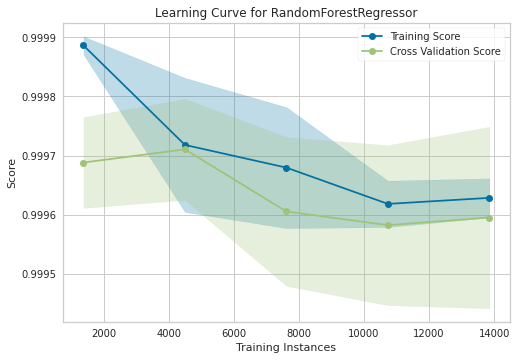

Out[10]: <matplotlib.axes._subplots.AxesSubplot at 0x7ff2a2c71610>

In [0]:
from yellowbrick.model_selection import LearningCurve

# Instantiate the regression model and visualizer
model = RandomForestRegressor(max_depth=5, random_state=0)
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(Xtrain_Sparse, y_train)        # Fit the data to the visualizer
visualizer.show() 

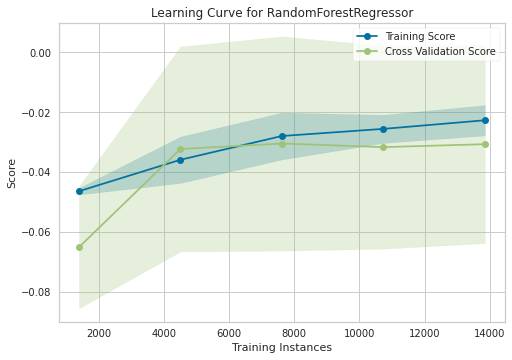

Out[11]: <matplotlib.axes._subplots.AxesSubplot at 0x7ff2a2ad6910>

In [0]:
# Instantiate the regression model and visualizer
model = RandomForestRegressor(max_depth=5, random_state=0)
visualizer = LearningCurve(model, scoring='neg_root_mean_squared_error')

visualizer.fit(Xtrain_Sparse, y_train)        # Fit the data to the visualizer
visualizer.show() 


## Approach 2

Same learning curves are plotted here for data obtained in second approach. For this data as well learning curve showing high variance and both training and cross validation curves are not converging which means that sample data used for modeling is not good enough for generalization.

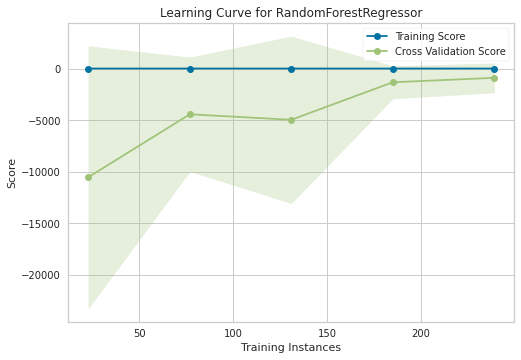

Out[36]: <matplotlib.axes._subplots.AxesSubplot at 0x7ff29ccfc070>

In [0]:
from yellowbrick.model_selection import LearningCurve

# Instantiate the regression model and visualizer
model = RandomForestRegressor(max_depth=5, random_state=0)
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(final_ds, target2)        # Fit the data to the visualizer
visualizer.show() 

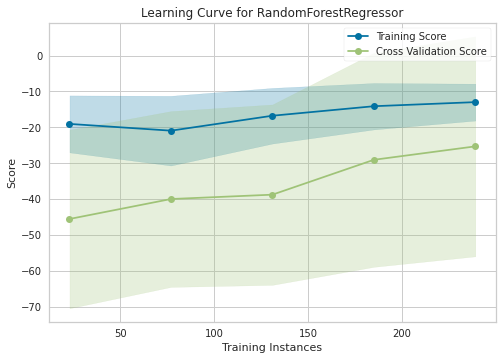

Out[37]: <matplotlib.axes._subplots.AxesSubplot at 0x7ff29cf6a1c0>

In [0]:
# Instantiate the regression model and visualizer
model = RandomForestRegressor(max_depth=5, random_state=0)
visualizer = LearningCurve(model, scoring='neg_root_mean_squared_error')

visualizer.fit(final_ds, target2)        # Fit the data to the visualizer
visualizer.show() 

# Conclusions

For this hackathon Libraries in United States was selected as business to build and evaluate model to predict if new selected location will help library to sustain at that location. Due to time constraint, learning curve (Spark mostly) and limitation of hackathon environment very small data set was selected for the state of Florida in approach 1 and combined with only census data. In approach 2 more libraries were included but combined only with census data. 

Following operations were performed on the data.

1.Precisely's location intelligence to build travel boundary

2.Combining data with census data. All features included in the final dataset

Data was trimmed and very small sample was taken from big data. Model evalualation indicates model does not generalize well with small sample and with just census information. To improve predictive capabaility more information needs to be added to the data e.g data from audience profile, family income, expenditure and so on. Even traffic data might help in improving model.

In summary,

Adding location intelligence definately helps in building predictive model.

# What Next?
                 
Due to time constraint, learning curve (Mainly spark/Scala used for the first time) and limitation of environment analysis and modeling was done with fewer records and fewer features and was combined only with census data. But with Precisely's SDK along with other datasets on consumer behavior, family income should improve model accuracy to correclty predict if given location is good for the business or not. Also in this notebook only one modeling technique has been used without hyper parameter tunning. Hyperparameter tunning might find better parameters. By adding more data and it should improve predictions and model can become more accurate. 

Neural networks can possibly be used for modeling.

In summary following can be done to improve predictive model

1.Use more features from audience profile, family income/expenditure along with census data.

2.Derive features from existing feature. Remove redudant features.

3.Use more data from all states

4.Use Neural networks for modeling

5.Include more libraries from other states. More data shall improve accuracy

6.More Hyperparameter tunning.

# References

1. <a href="http://informationr.net/ir/24-4/colis/colis1914.html"  target="_blank"> Research on Public Libraries are promoters of Social Sustainbilty </a>